# Learned Embeddings - AutoEncoders
This program will attempt to create embeddings for the categorical features using the pipelines code developed.

function ClickConnect(){
console.log("Working");
document.querySelector("colab-connect-button").shadowRoot.getElementById('connect').click()
}
setInterval(ClickConnect,60000)

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy as copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import sys
sys.path.append('drive/My Drive/Thesis/Collab Notebooks/')

In [0]:
# using the latest updated file
data = pd.read_csv("drive/My Drive/Thesis/data/Data_Engineering/Edited_Raw_Data/v5_Sorted_Raw_Db_with_RUL_imputed.csv", sep=',', low_memory=False)
#data = pd.read_csv("drive/My Drive/Thesis/data/Feature_Engineering/KNN_Imputed_Datasets/KNN_Imputed_k_40.csv", sep=',', low_memory=False)
#data = pd.read_csv("drive/My Drive/Thesis/data/Data_Engineering/Edited_Raw_Data/v2_Sorted_Database.csv", sep=',', low_memory=False)
data2 = pd.read_csv("drive/My Drive/Thesis/data/Embedding_Data/v2_sorted_data_new.csv", sep=',', low_memory=False)


## Pipeline Extraction

In [0]:
# Applying the Extraction pipeline
# first stage of the pipeline
from extraction_pipeline import *
from category_pipeline import *

## Category Pipeline


In [6]:
# Date transformation
#data = extraTrasfromToCategory(data, debug=True)

'''
# Zero Variance removal
data = removeZeroCategory(data)
print ('After all removal pipeline - ',data.shape)
'''



"\n# Zero Variance removal\ndata = removeZeroCategory(data)\nprint ('After all removal pipeline - ',data.shape)\n"

In [0]:
# load this information from the save csv file
cat_features_df = pd.read_csv("drive/My Drive/Thesis/data/Embedding_Data/cat_embedding_details.csv", sep=',', low_memory=False)

In [8]:
cat_features_df

,Feature,Cardinality,Embedding_Size
0,DAY,2,1
1,MONTH,12,6
2,YEAR,4,2
3,VAR_7MA_FRONT_AXLE_TYPE,2,1
4,VAR_DPX_ENGINE_TYPE,3,2
...,...,...,...
69,VFE_0009_LTVF_TYPE,6,3
70,VFE_0005_VEHICLE_OPERATION_DIGIT1,5,3
71,VFE_0006_VEHICLE_OPERATION_DIGIT2,9,5
72,VFE_0007_CAB_HEIGHT,7,4


# Training and Validation Data Extraction
Based on the previous understanding. We are going to have to nature of data
- Numerical Features and Catgorical Features.
The Numerical features have a total of 362 features while the Categorical feature has 74 features.

We will have Training and Validation data.

In [0]:
# load feature names from db
feature_names_cat = pd.read_csv("drive/My Drive/Thesis/data/Embedding_Data/feature_names_cat.csv", sep=',', low_memory=False)
feature_names_num = pd.read_csv("drive/My Drive/Thesis/data/Embedding_Data/feature_names_num.csv", sep=',', low_memory=False)


In [0]:
# fetch the categorical and numerical features
cat_features = feature_names_cat['Categorical'].values
num_features = feature_names_num['Numerical'].values


In [0]:
features = list(cat_features)
features.append('T_CHASSIS')

In [0]:
data = data[features].dropna()

In [0]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
# for cross validation, we can use Group KFold spliting - GroupShuffleSplit


In [0]:
# Function for assisting in spliting the data
def validationSplit(data_in, split=0.2, toShuffle=False):
  # here we will split the data
  # splitting by chassis
  chassis_data = data_in['T_CHASSIS'].unique()
  # splitting the chassis data
  c_train, c_val = train_test_split(chassis_data, test_size=split, random_state=42, shuffle=toShuffle)
  # extracting out the training and testing
  train_data = data_in[data_in['T_CHASSIS'].isin(c_train)].reset_index(drop=True)
  test_data = data_in[data_in['T_CHASSIS'].isin(c_val)].reset_index(drop=True)
  return train_data, test_data


In [0]:
# Function for assisting in spliting the data
def crossValidationSplit(data_in, split=0.2, toShuffle=False):
  # here we will split the data based on their chassis grouping
  chassis_group = data['T_CHASSIS'].values
  ## generating the Group Parameters
  c_split = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
  '''
  # splitting the data
  for train_idx, test_idx in c_split.split(data.values, groups=chassis_group):
    print("TRAIN:", data.values[train_idx].shape, "TEST:", data.values[test_idx].shape)
  '''
  return c_split

### Train Splitting

In [16]:
#data_t.to_csv("drive/My Drive/Thesis/data/Embedding_Data/chassis_training_data.csv", sep=',', index=False)
#data_v.to_csv("drive/My Drive/Thesis/data/Embedding_Data/chassis_testing_data.csv", sep=',', index=False)

data_t, data_v = validationSplit(data, split=0.2)
data_t.shape, data_v.shape

((16131, 75), (3823, 75))

## Category Summary
In summary, we have a total of 74 categories. They can be used to filter new data sources instead of going through the whole extaction and category pipeline all over again.

## Embeddings

In order to apply embeddings for out categorical variables. We need to first determine which features are categorical variable and which are not. We need to ensure we caputure all possible cases of the categorical features. 

Okay, then for each categorical variable we need to capture the cardinalty of the feature iteself.

In [0]:
# use tensorflow version 2
%tensorflow_version 2.x

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Reshape, Concatenate, Dense, Flatten, Dropout

from tensorflow.keras.callbacks import TensorBoard
import os
import datetime

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
#from tensorflow.summary import create_file_writer
#  TensorFlow and the TensorBoard HParams plugin:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp


### Saving and Loading Embeddings

In [0]:
# Goal
'''
Write a function, when given a categorical variable, it will generate the vector representation for that variable.
In order to achieve that, we first need to map very categorical variable to some numerical index value. This value 
has to be unique and not random. 
'''

def transfromForEmbed(data_cat, cat_feature_name='', cat_mapping=''):
  # find the cat_index for all the features
  def findCatIndex(x):
    return int(cat_mapping[cat_mapping[cat_feature_name] == x][cat_feature_name+'_index'].values[0])
  output = data_cat[cat_feature_name].apply(findCatIndex) 
  return output

def embedTransform(model=None, variable='', cat_feature_name='', cat_mapping='', return_type=1):
  # Given a categorical variable, produce the embedded vector
  # Find the index of the categorical variable in the cat_mapping dataframe
  cat_index = int(cat_mapping[cat_mapping[cat_feature_name] == variable][cat_feature_name+'_index'].values[0])
  if return_type == 0:
    return cat_index
  # fetch the embeddings weights
  pre_embedding = "Embedding_layer_"
  embed_layer = model.get_layer(name=pre_embedding+cat_feature_name)
  embedd_vector = embed_layer.get_weights()[0][cat_index]
  return embedd_vector


In [0]:
# load from file
cat_mappings = pd.read_csv("drive/My Drive/Thesis/data/Embedding_Data/cat_mappings.csv", sep=',', low_memory=False)


In [0]:
# load the embedding model
from tensorflow.keras.models import load_model
# identical to the previous one
embed_model = load_model("drive/My Drive/Thesis/data/Embedding_Data/embedding_model_low_mae.h5")


In [23]:
# Cosine similarity calc
# find the embedding vector for feature CABH210 in VFE_0007_CAB_HEIGHT
'''
my_vector1 = embedTransform(embed_model, variable='CABH175', cat_feature_name='VFE_0007_CAB_HEIGHT', cat_mapping=cat_mappings)
my_vector2 = embedTransform(embed_model, variable='CABH165', cat_feature_name='VFE_0007_CAB_HEIGHT', cat_mapping=cat_mappings)
my_vector3 = embedTransform(embed_model, variable='CABH210', cat_feature_name='VFE_0007_CAB_HEIGHT', cat_mapping=cat_mappings)
my_vector4 = embedTransform(embed_model, variable='CABH230', cat_feature_name='VFE_0007_CAB_HEIGHT', cat_mapping=cat_mappings)
my_vector5 = embedTransform(embed_model, variable='Low', cat_feature_name='VFE_0007_CAB_HEIGHT', cat_mapping=cat_mappings)
'''
'''
x1 = output_embeddings[0]
x2 = output_embeddings[1]

# calculating the cosing similarity of two vectors in the orginal space
a_dot = np.dot(x1, x2)
similar = a_dot / (np.linalg.norm(x1) * np.linalg.norm(x2))
similar
'''

'\nx1 = output_embeddings[0]\nx2 = output_embeddings[1]\n\n# calculating the cosing similarity of two vectors in the orginal space\na_dot = np.dot(x1, x2)\nsimilar = a_dot / (np.linalg.norm(x1) * np.linalg.norm(x2))\nsimilar\n'

### Loading the Keras Embeddings

In [0]:
### Creating the Keras Embeddings Mode

def create_model(saved_model=None):
  # IDs representing 1-hot encodings
  # Need to create the input for all features
  cat_embedding_input_layers = []

  cat_reshape_layers = []
  # Embeddings for the first cat feature
  id_feature = 0
  # create an array of embeddings layers
  cat_embedding_layers = []

  # interate through categorical varaibles
  for id_feature in range(cat_features_df.shape[0]):
    # creating the input layer for the embeddings
    #input_layer = Input(shape=(1,), name="Input_layer_"+cat_features_df.loc[id_feature, 'Feature'])
    input_layer = Input(shape=(1,), name="Input_layer_"+cat_features_df.loc[id_feature, 'Feature'])
    cat_embedding_input_layers.append(input_layer)
    # embedding size 
    layer_embedding_size = cat_features_df.loc[id_feature, 'Embedding_Size']
    # create the embedding layers
    embed_weights = saved_model.get_layer(name="Embedding_layer_"+cat_features_df.loc[id_feature, 'Feature']).get_weights()
    #embedded_layer.trainable = False
    embedded_layer = Embedding(input_dim=cat_features_df.loc[id_feature, 'Cardinality'], output_dim=layer_embedding_size, 
                               name="Embedding_layer_"+cat_features_df.loc[id_feature, 'Feature'], input_length = 1, trainable=False, weights=embed_weights)(input_layer)
    cat_embedding_layers.append(embedded_layer)
    # add a reshape of the embedding layers
    reshape_layer = Reshape(target_shape=(layer_embedding_size,))(embedded_layer)
    # appends the rehshape models together
    cat_reshape_layers.append(reshape_layer)

  ### Create A combined embedding layers only
  combined_emb = Concatenate(axis=1, name='combined_embeddings')(cat_reshape_layers)
  
  ### the output of the combine embedding model is 169 vectors

  ### creating a model based on the trained weights
  model_emb = Model(inputs=cat_embedding_input_layers, outputs=combined_emb, name="Categorical_Embeddings")

  # compile the model - for a regression model
  model_emb.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])
  # compile the model - for a classification problem
  # model.compile(loss='binary_crossentropy', optimizer='adam')
  return model_emb

def train_model(model, x_train, y_train, x_test, y_test, epochs, batch_size, early_stop_callback=None, tensorboard_callback=None):
  # fitting the model
  #model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(XTest, yTest), callbacks=[early_stop, tensorboard_callback])
  model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[early_stop_callback, tensorboard_callback])
  return model

In [0]:
## For each run, log an hparams summary with the hyperparameters and final accuracy:
def run(my_model, x_train, y_train, epochs, batch_size, early_stop_callback, tensorboard_log):
  model = None
  model = create_model(my_model)
  model_output = train_model(model, x_train, y_train, epochs, batch_size, early_stop_callback=early_stop_callback, tensorboard_callback=tensorboard_log)
  # do something with the metrics
  return model_output

In [0]:
# plot the model
#plot_model(model=model_emb, to_file='drive/My Drive/Thesis/data/Embedding_Data/model_image.png', show_shapes=True, dpi=300)
#plot_model(model=model_emb, to_file='drive/My Drive/Thesis/data/Embedding_Data/model_new.png', show_shapes=True, dpi=300)

## Inputs to the Network

We need to create a list of inputs, such that each categorical feature has it's own list of values and the last list will be a 2D array of the continous values. As shown above.

The size of the list of inputs : ip = n_cat + 1

Remember for each of the embedding network we had set input-size =1 we are taking 1 value each from all the list (except the last list) and sending it to the combined network for training. For the last list, each value itself is a list having the other columns values, and this is sent to the models_rest network

In [0]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [0]:
def transfromForEmbed(data_cat, cat_feature_name='', cat_mapping='', type=None):
  # find the cat_index for all the features
  def findCatIndex(x):
    return int(cat_mapping[cat_mapping[cat_feature_name] == x][cat_feature_name+'_index'].values[0])
  if type is not None:
    output = findCatIndex(data_cat[cat_feature_name])
    return np.array([output])
  else:
    output = data_cat[cat_feature_name].apply(findCatIndex) 
    return output.values

# function to reformat the input data into the necessary input data for our network to be trained on.
def network_input_process(data_num=None, data_cols=None, y_output=None, input_type=1):
  # create a list of inputs. 
  try:
    cat_size = data_cols.shape[1]
    columns_name = data_cols.columns
    col_type = None
  except:
    cat_size = data_cols.shape[0]
    columns_name = data_cols.index
    col_type = 1

  # define the size of the network list inputs
  network_inputs = [None] * (cat_size)

  # add inputs to the list
  # for the categorical inputs

  for i in range(cat_size):
    #network_inputs[i] = pd.factorize(data_cols.iloc[:, i].values)[0]
    # map each categorical variable to their respective index values
    #print (columns_name[i])
    #network_inputs[i] = transfromForEmbed(data_cols, cat_feature_name=columns_name[i], cat_mapping=cat_mappings, type=col_type)
    network_inputs[i] = data_cols.loc[:, columns_name[i]].values

  return network_inputs, y_output.values

In [29]:
data_t, data_v = validationSplit(data2, split=0.2)
data_t.shape, data_v.shape

((16131, 75), (3823, 75))

In [0]:
# creating the training inputs

# create the requirment for the embedding model
XTrain, yTrain = network_input_process(data_num=None, data_cols=data_v[cat_features], y_output=data_v.iloc[:,3])

In [31]:
XTrain[10].shape

(3823,)

## Embedding Model

In [0]:
#fetch our the trained embedding model the model
model_embeddings = None
model_embeddings = create_model(saved_model=embed_model)

In [0]:
#model_embeddings.fit(XTrain, yTrain, epochs=1, workers=-1)

In [0]:
# Embedding Prediction
embed_data = model_embeddings.predict(XTrain)

# View Embeddings

In [0]:
# import TSNE and PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [0]:
tsne = TSNE(n_components=2, n_iter=1000, perplexity=50)
reduced_tsne = tsne.fit_transform(embed_data)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(embed_data)

In [37]:
# label encoding for the chassis
chassis_target = pd.factorize(data_v.loc[:, 'T_CHASSIS'].values)[0]
chassis_target.shape

(3823,)

In [0]:
codes, uniques = pd.factorize(data_v.loc[:, 'T_CHASSIS'].values)

In [39]:

##### Cosine Similarity measure
x1 = embed_data[512]
x2 = embed_data[696]


# calculating the cosing similarity of two vectors in the orginal space
a_dot = np.dot(x1, x2)
similar = a_dot / (np.linalg.norm(x1) * np.linalg.norm(x2))
similar


0.50399524

In [40]:
'''
0-746402 and O-678360, 0-778558
Chekc distance from 
O-803915 and O-719898
O-719156 and O-753014
'''

'\n0-746402 and O-678360, 0-778558\nChekc distance from \nO-803915 and O-719898\nO-719156 and O-753014\n'

Observation between 0-746402 and O-678360. Calculating the cosine similarity between those two embedding points shows a value of 0.75161475. The farthest point to this is O-803915 and the similarity value is 0.25650138

0.7942, 0.6742973 (ElU), 0.4070125 (PReLU)

In [41]:
np.unique(chassis_target[900:1000])

array([18, 19, 20])

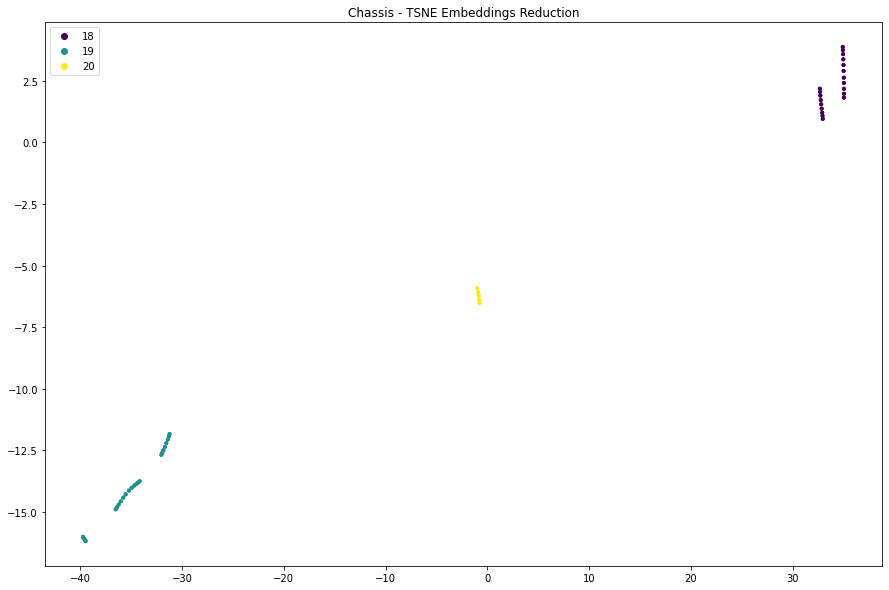

In [42]:
fig = plt.figure(figsize=(15,10))
scatter = plt.scatter(reduced_tsne[900:1000,0], reduced_tsne[900:1000,1], c=chassis_target[900:1000], marker='.', label=np.unique(chassis_target[900:1000]))
plt.title('Chassis - TSNE Embeddings Reduction')
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(chassis_target[900:1000])))

In [43]:
## 
'''
0-746402 and O-678360, 0-778558
Chekc distance from 
O-803915 and O-719898
O-719156 and O-753014
'''
## '''

'\n0-746402 and O-678360, 0-778558\nChekc distance from \nO-803915 and O-719898\nO-719156 and O-753014\n'

In [44]:
chassis_target[657:710]

array([12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 14])

In [45]:
data_v.loc[5:100, 'T_CHASSIS'].values

array(['O-803915', 'O-803915', 'O-803915', 'O-803915', 'O-803915',
       'O-803915', 'O-803915', 'O-803915', 'O-803915', 'O-803915',
       'O-803915', 'O-803915', 'O-803915', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-689766',
       'O-689766', 'O-689766', 'O-689766', 'O-689766', 'O-6897

In [0]:
pd.set_option('display.max_rows', 500)


In [47]:
data_v.loc[657:710, :]

,DAY,MONTH,YEAR,VAR_7MA_FRONT_AXLE_TYPE,VAR_DPX_ENGINE_TYPE,VAR_T1X_PTO_ENGINE_MOUNTED_REAR,VAR_4DX_FRONT_BUMPER,VAR_F1X_REAR_AXLE_LOAD,VAR_FTX_GROUND_CLEARANCE_FA,VAR_CKX_VEHICLE_PROFILE,VAR_KTX_ENGINE_EMISSION_CONTROL,VAR_3ZB_TRANSMISSION_PTO_TORQUE_CAP,VAR_QCX_TOPOGRAPHY,VAR_YLX_REAR_SUSPENSION_SYSTEM,VAR_DKX_GROSS_COMBINATION_WEIGHT,VAR_2RB_BATTERY_MAINTENANCE,VAR_FAX_STEERING_WHEEL_POS,VAR_2CX_CAB_VERSION,VAR_2DX_REAR_CAB_SUSPENSION,VAR_GSX_CHASSIS_HEIGHT,VAR_FFX_PUSHER_AXLE_FEATURES,VAR_5CB_AIR_SUSP_FEATURE_SOFTWARE,VAR_2GB_CLUTCHABLE_AIR_COMPRESSOR,VAR_5NX_ENGINE_BLOCK_HEATER,VAR_TAX_REAR_AXLE_RATIO,VAR_A3A_IDLE_SHUTDOWN,VAR_2LX_FRONT_CAB_SUSPENSION,VAR_RUX_GEAR_SHIFTING_SYSTEM,VAR_U3X_BRAKE_FRONT,VAR_T4X_PTO_TRANSM_MOUNTED,VAR_UBX_HYDRAULIC_PUMP_ENG_MTD,VAR_4QB_BODYBUILDER_EL_INTERFCAB_CHAS,VAR_REX_CRANK_CASE_VENTILATION,VAR_78X_TRANSPORT_CYCLE,VAR_T2X_TRANSMISSIONRETARDER_COOLER,VAR_U4X_BRAKE_DRIVE_REAR,VAR_FVX_FRONT_AXLE_LOAD,VAR_VWX_COMPRESSOR_CAPACITY,VAR_DAX_AXLE_ARRANGEMENT,VAR_H1B_TURBO_APPLICATION,VAR_FDX_REAR_AXLE_ARRANGEMENT,VAR_7PX_HYDRAULIC_PUMP_GEARBOX_MOUNTED,VAR_7NA_FRONT_SUSPENSION_INSTALLATION,VAR_LKX_DRIVER_STATE_SENSING_SYSTEM,VAR_QWX_TURBO,VAR_FZX_FRONT_AXLE_ARRANGEMENT,VAR_V6X_RETARDER,VAR_K4C_VEHICLE_UPTIME_SETTINGS,VAR_0RA_REGENERATION_CONTROLS_DPF,VAR_YKX_FRONT_SUSPENSION_SYSTEM,VAR_T3X_PTO_ENGINE_REAR_MOUNTED,VAR_PJX_ALTERNATOR_CAPACITY,VAR_41X_PARKING_HEATER,VAR_D7C_WHOLE_VEHICLE_TYPE_APPROVAL,VAR_5JB_TELEMATICS_COMMUNICAT_GATEWAYS,VAR_RWX_TRANSMISSION,VAR_DHX_ROAD_CONDITION,VAR_2EX_CAB_TILT_PUMP,VAR_D9C_EMISSION_LEVEL,VAR_DDX_CHASSIS_TYPE,VAR_O8A_ENGINE_PTO_TORQUE_CAPACITY,VAR_33A_CAB_HEIGHT,VAR_J2A_ACTIVE_STEERING,VAR_N9C_ADR_CLASSIFICATION,VFE_0001_HORSE_POWER,VFE_0002_GROSS_COMBINATION_WEIGHT_BIN,VFE_0003_ENGINE_GENERATION,VFE_0004_REAR_AXLE_LOAD_BIN,VFE_0005_REAR_AXLE_RATIO_BIN,VFE_0009_LTVF_TYPE,VFE_0005_VEHICLE_OPERATION_DIGIT1,VFE_0006_VEHICLE_OPERATION_DIGIT2,VFE_0007_CAB_HEIGHT,VFE_0008_HAS_PTO,T_CHASSIS
657,0,10,3,0,1,0,0,2,2,0,0,1,1,0,0,0,0,2,0,1,0,0,0,0,4,0,0,0,1,1,0,2,0,0,1,1,2,1,2,1,2,0,1,1,0,0,0,0,0,1,0,0,0,0,0,4,0,0,0,1,0,2,1,1,1,0,0,2,2,2,1,0,2,1,O-753014
658,1,3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,6,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,2,0,0,0,0,2,1,1,3,0,O-754173
659,0,3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,6,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,2,0,0,0,0,2,1,1,3,0,O-754173
660,1,4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,6,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,2,0,0,0,0,2,1,1,3,0,O-754173
661,0,4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,6,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,2,0,0,0,0,2,1,1,3,0,O-754173
662,1,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,6,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,2,0,0,0,0,2,1,1,3,0,O-754173
663,0,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,6,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,2,0,0,0,0,2,1,1,3,0,O-754173
664,1,6,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,6,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,2,0,0,0,0,2,1,1,3,0,O-754173
665,0,6,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,6,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,2,0,0,0,0,2,1,1,3,0,O-754173
666,1,7,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,6,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,2,0,0,0,0,2,1,1,3,0,O-754173


In [48]:
data_v.loc[465:532, :]

,DAY,MONTH,YEAR,VAR_7MA_FRONT_AXLE_TYPE,VAR_DPX_ENGINE_TYPE,VAR_T1X_PTO_ENGINE_MOUNTED_REAR,VAR_4DX_FRONT_BUMPER,VAR_F1X_REAR_AXLE_LOAD,VAR_FTX_GROUND_CLEARANCE_FA,VAR_CKX_VEHICLE_PROFILE,VAR_KTX_ENGINE_EMISSION_CONTROL,VAR_3ZB_TRANSMISSION_PTO_TORQUE_CAP,VAR_QCX_TOPOGRAPHY,VAR_YLX_REAR_SUSPENSION_SYSTEM,VAR_DKX_GROSS_COMBINATION_WEIGHT,VAR_2RB_BATTERY_MAINTENANCE,VAR_FAX_STEERING_WHEEL_POS,VAR_2CX_CAB_VERSION,VAR_2DX_REAR_CAB_SUSPENSION,VAR_GSX_CHASSIS_HEIGHT,VAR_FFX_PUSHER_AXLE_FEATURES,VAR_5CB_AIR_SUSP_FEATURE_SOFTWARE,VAR_2GB_CLUTCHABLE_AIR_COMPRESSOR,VAR_5NX_ENGINE_BLOCK_HEATER,VAR_TAX_REAR_AXLE_RATIO,VAR_A3A_IDLE_SHUTDOWN,VAR_2LX_FRONT_CAB_SUSPENSION,VAR_RUX_GEAR_SHIFTING_SYSTEM,VAR_U3X_BRAKE_FRONT,VAR_T4X_PTO_TRANSM_MOUNTED,VAR_UBX_HYDRAULIC_PUMP_ENG_MTD,VAR_4QB_BODYBUILDER_EL_INTERFCAB_CHAS,VAR_REX_CRANK_CASE_VENTILATION,VAR_78X_TRANSPORT_CYCLE,VAR_T2X_TRANSMISSIONRETARDER_COOLER,VAR_U4X_BRAKE_DRIVE_REAR,VAR_FVX_FRONT_AXLE_LOAD,VAR_VWX_COMPRESSOR_CAPACITY,VAR_DAX_AXLE_ARRANGEMENT,VAR_H1B_TURBO_APPLICATION,VAR_FDX_REAR_AXLE_ARRANGEMENT,VAR_7PX_HYDRAULIC_PUMP_GEARBOX_MOUNTED,VAR_7NA_FRONT_SUSPENSION_INSTALLATION,VAR_LKX_DRIVER_STATE_SENSING_SYSTEM,VAR_QWX_TURBO,VAR_FZX_FRONT_AXLE_ARRANGEMENT,VAR_V6X_RETARDER,VAR_K4C_VEHICLE_UPTIME_SETTINGS,VAR_0RA_REGENERATION_CONTROLS_DPF,VAR_YKX_FRONT_SUSPENSION_SYSTEM,VAR_T3X_PTO_ENGINE_REAR_MOUNTED,VAR_PJX_ALTERNATOR_CAPACITY,VAR_41X_PARKING_HEATER,VAR_D7C_WHOLE_VEHICLE_TYPE_APPROVAL,VAR_5JB_TELEMATICS_COMMUNICAT_GATEWAYS,VAR_RWX_TRANSMISSION,VAR_DHX_ROAD_CONDITION,VAR_2EX_CAB_TILT_PUMP,VAR_D9C_EMISSION_LEVEL,VAR_DDX_CHASSIS_TYPE,VAR_O8A_ENGINE_PTO_TORQUE_CAPACITY,VAR_33A_CAB_HEIGHT,VAR_J2A_ACTIVE_STEERING,VAR_N9C_ADR_CLASSIFICATION,VFE_0001_HORSE_POWER,VFE_0002_GROSS_COMBINATION_WEIGHT_BIN,VFE_0003_ENGINE_GENERATION,VFE_0004_REAR_AXLE_LOAD_BIN,VFE_0005_REAR_AXLE_RATIO_BIN,VFE_0009_LTVF_TYPE,VFE_0005_VEHICLE_OPERATION_DIGIT1,VFE_0006_VEHICLE_OPERATION_DIGIT2,VFE_0007_CAB_HEIGHT,VFE_0008_HAS_PTO,T_CHASSIS
465,1,11,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6,0,0,0,1,0,0,1,1,0,0,1,2,1,2,0,2,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,2,2,2,3,0,0,0,O-678360
466,1,11,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,2,1,1,0,1,O-705356
467,0,11,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,2,1,1,0,1,O-705356
468,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,2,1,1,0,1,O-705356
469,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,2,1,1,0,1,O-705356
470,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,2,1,1,0,1,O-705356
471,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,2,1,1,0,1,O-705356
472,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,2,1,1,0,1,O-705356
473,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,2,1,1,0,1,O-705356
474,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,2,1,1,0,1,O-705356


In [49]:
np.unique(chassis_target[:1000])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

# Visualization with Chassis ID Numbered with digits

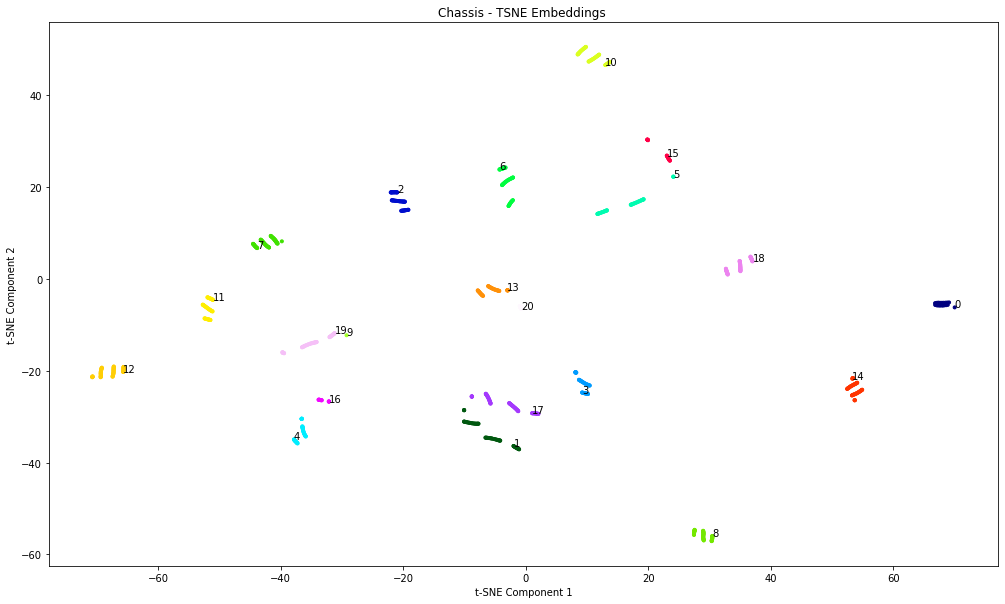

In [50]:
fig = plt.figure(figsize=(17, 10))
scatter2 = plt.scatter(reduced_tsne[:1000,0], reduced_tsne[:1000,1], c=chassis_target[:1000], cmap=plt.cm.get_cmap("gist_ncar"), marker='.')
plt.title('Chassis - TSNE Embeddings ')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

counter = []
for i, txt in enumerate(chassis_target[:1000]):
  if txt not in counter:
    plt.annotate(txt, (reduced_tsne[i,0], reduced_tsne[i,1]))
    counter.append(txt)

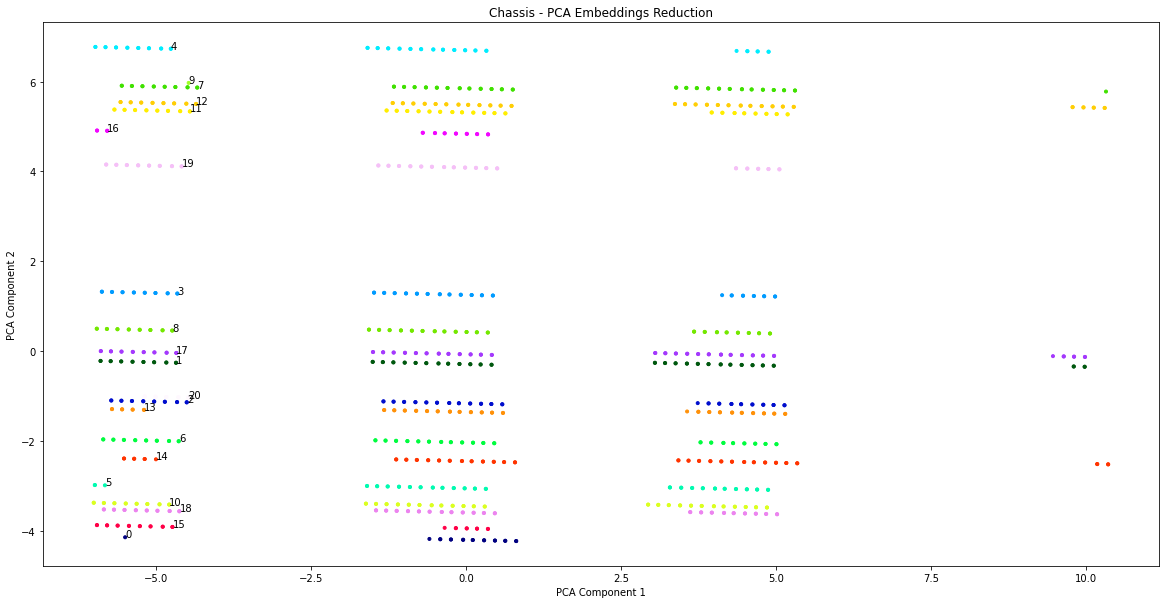

In [53]:
fig = plt.figure(figsize=(20,10))
plt.scatter(pca_data[:1000,0], pca_data[:1000,1], c=chassis_target[:1000],cmap=plt.cm.get_cmap("gist_ncar"), marker='.')
plt.title('Chassis - PCA Embeddings Reduction')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
counter = []
for i, txt in enumerate(chassis_target[:1000]):
  if txt not in counter:
    plt.annotate(txt, (pca_data[i,0], pca_data[i,1]))
    counter.append(txt) 

In [52]:
'''
Chekc distance from 
O-803915 and O-719898
O-719156 and O-753014
'''

'\nChekc distance from \nO-803915 and O-719898\nO-719156 and O-753014\n'

# Visualization using alphanumeric Chassis ID

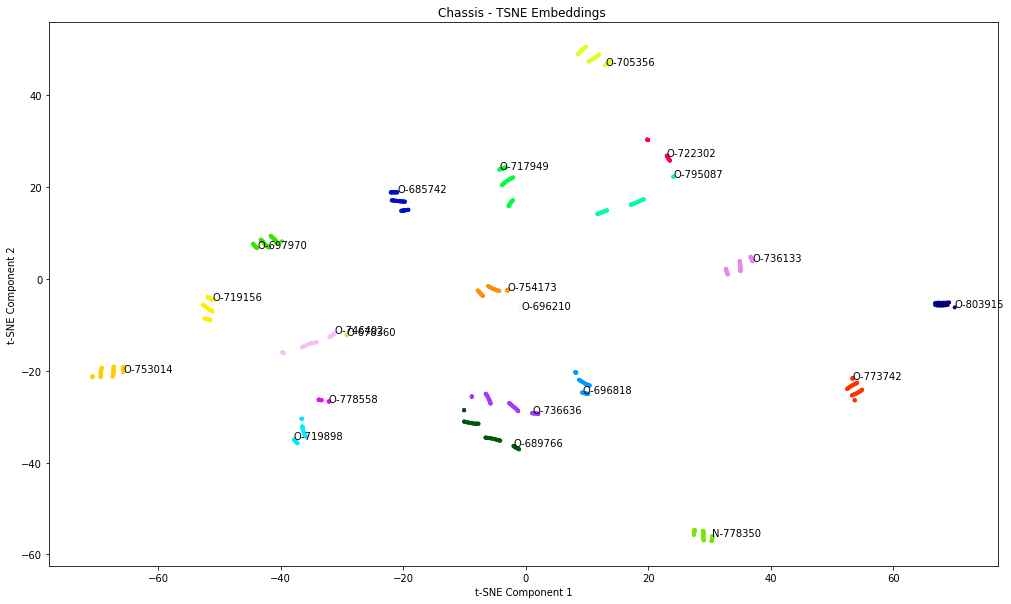

In [56]:
fig = plt.figure(figsize=(17, 10))
scatter2 = plt.scatter(reduced_tsne[:1000,0], reduced_tsne[:1000,1], c=chassis_target[:1000], cmap=plt.cm.get_cmap("gist_ncar"), marker='.')
plt.title('Chassis - TSNE Embeddings ')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

counter = []
for i, txt in enumerate(data_v.loc[:1000, 'T_CHASSIS'].values):
  if txt not in counter:
    plt.annotate(txt, (reduced_tsne[i,0], reduced_tsne[i,1]))
    counter.append(txt)

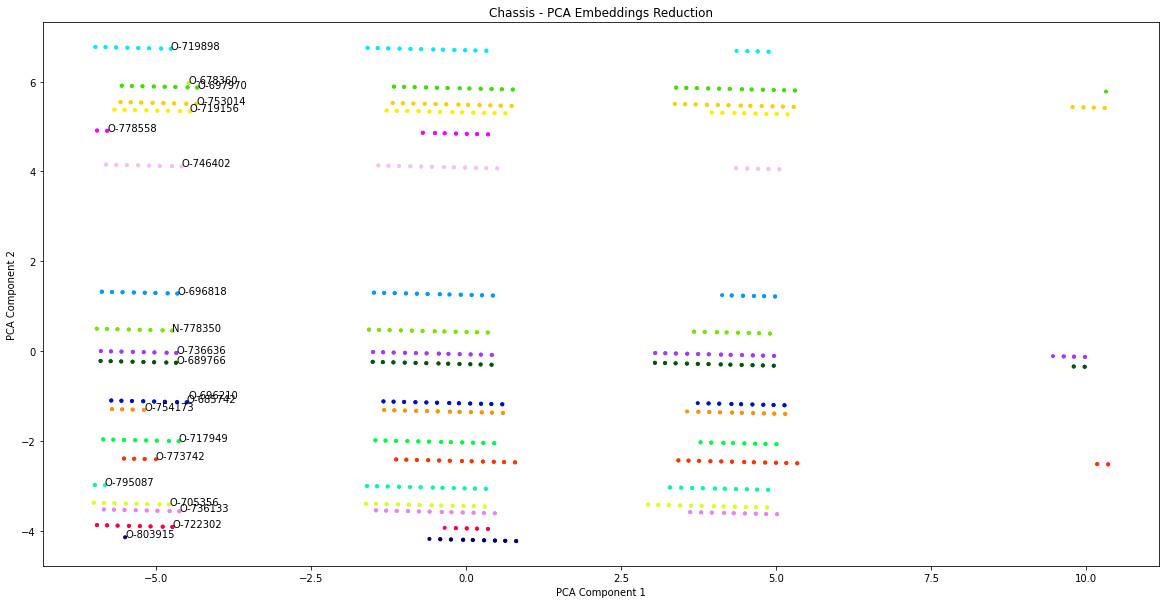

In [55]:

fig = plt.figure(figsize=(20,10))
plt.scatter(pca_data[:1000,0], pca_data[:1000,1], c=chassis_target[:1000],cmap=plt.cm.get_cmap("gist_ncar"), marker='.')
plt.title('Chassis - PCA Embeddings Reduction')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
counter = []
for i, txt in enumerate(data_v.loc[:1000, 'T_CHASSIS'].values):
  if txt not in counter:
    plt.annotate(txt, (pca_data[i,0], pca_data[i,1]))
    counter.append(txt) 

